<a id='top'></a>

# 2) Gradient Boosted Chance Quality Model from Shots Data
##### Notebook to further imrpove the Chance Quality Model (CQM) model created in the previous notebook from a provided sample of just under 11,000 shots, series through the application of the XGBoost Gradient Boosting algorithm.

### By [Edd Webster](https://www.twitter.com/eddwebster)
Notebook first written: 26/03/2021<br>
Notebook submitted for review: 28/03/2021<br>
Notebook last updated: 27/03/2021

![title](../../img/expected_goals_visual.png)

Photo credit to David Sumpter ([@Soccermatics](https://twitter.com/Soccermatics?)).

---

## <a id='introduction'>Introduction</a>
This notebook is a short walk-through of how to create an Expected Goals (xG) model using a just under 11,00 shots, in [Python](https://www.python.org/), using [pandas](http://pandas.pydata.org/) DataFrames, [scikit-learn](https://scikit-learn.org/stable/) for Machine Learning, and [matplotlib](https://matplotlib.org/contents.html?v=20200411155018) visualisations.

For more information about this notebook and the author, I am available through all the following channels:
*    [eddwebster.com](https://www.eddwebster.com/);
*    edd.j.webster@gmail.com;
*    [@eddwebster](https://www.twitter.com/eddwebster);
*    [linkedin.com/in/eddwebster](https://www.linkedin.com/in/eddwebster/);
*    [github/eddwebster](https://github.com/eddwebster/); and
*    [public.tableau.com/profile/edd.webster](https://public.tableau.com/profile/edd.webster).

![title](../../img/edd_webster/fifa21eddwebsterbanner.png)

The accompanying GitHub repository for this notebook can be found [here](https://github.com/eddwebster/mcfc_submission/) and a static version of this notebook can be found [here](https://nbviewer.jupyter.org/github/eddwebster/mcfc_submission/blob/main/notebooks/chance_quality_modelling/Creating%20a%20Chance%20Quality%20Model%20from%20Shots%20Data.ipynb).

___

## <a id='notebook_contents'>Notebook Contents</a>
1.      [Notebook Dependencies](#section1)<br>
2.      [Project Brief](#section2)<br>
3.      [Introduction to XGBoost](#section3)<br>
4.      [Bagging Vs. Boosting](#section4)<br>
5.      [Theory Behind the XGBoost Algorithm](#section5)<br>
6.      [Data Sources](#section6)<br>
        1.    [Data Dictionary](#section6.1)<br>
        2.    [Creating the DataFrame](#section6.2)<br>
        3.    [Initial Data Handling](#section6.3)<br>    
7.      [Initial Modeling](#section7)<br>
8.      [k-fold Cross Validation using XGBoost](#section8)<br>
9.      [Feature Importance with XGBoost](#section9)<br>
10.     [Visualisation of XGBoost Tree](#section10)<br>
11.     [Hyperparameter Optimisation](#section11)<br>
12.     [Final Optimised XGBoost Model](#section12)<br>
13.     [Performance comparison of XGBoost with Logistic Regression](#section13)<br>
14.     [Assessment of the Performance of the Teams in Game 2 of the Metrica Sports Shot Data](#section14)<br>
15.     [Summary](#section15)<br>
16.     [Next Steps](#section16)<br>
17.     [References and Further Reading](#section17)<br>

---

## <a id='#section1'>1. Notebook Dependencies</a>
This notebook was written using [Python 3](https://docs.python.org/3.7/) and requires the following libraries:
*    [`Jupyter notebooks`](https://jupyter.org/) for this notebook environment with which this project is presented;
*    [`NumPy`](http://www.numpy.org/) for multidimensional array computing;
*    [`pandas`](http://pandas.pydata.org/) for data analysis and manipulation;
*    [`matplotlib`](https://matplotlib.org/contents.html?v=20200411155018) for data visualisations; and
*    [`scikit-learn`](https://scikit-learn.org/stable/index.html) for Machine Learning.

All packages used for this notebook except can be obtained by downloading and installing the [Conda](https://anaconda.org/anaconda/conda) distribution, available on all platforms (Windows, Linux and Mac OSX). Step-by-step guides on how to install Anaconda can be found for Windows [here](https://medium.com/@GalarnykMichael/install-python-on-windows-anaconda-c63c7c3d1444) and Mac [here](https://medium.com/@GalarnykMichael/install-python-on-mac-anaconda-ccd9f2014072), as well as in the Anaconda documentation itself [here](https://docs.anaconda.com/anaconda/install/).

### Import Libraries and Modules

In [1]:
%load_ext autoreload
%autoreload 2

# Python ≥3.5 (ideally)
import platform
import sys, getopt
assert sys.version_info >= (3, 5)
import csv

# Import Dependencies
%matplotlib inline

# Math Operations
import numpy as np
import math
from math import pi

# Datetime
import datetime
from datetime import date
import time

# Data Preprocessing
import pandas as pd
import os
import re
import random
from io import BytesIO
from pathlib import Path

# Reading directories
import glob
import os
from os.path import basename

# Working with JSON
import json
from pandas.io.json import json_normalize

# Data Visualisation
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import patches
from matplotlib.patches import Arc
from matplotlib.colors import ListedColormap
import seaborn as sns
plt.style.use('seaborn-whitegrid')
import missingno as msno
from xgboost import plot_tree
import graphviz

# Downloading data sources
from urllib.parse import urlparse
from urllib.request import urlopen, urlretrieve
from zipfile import ZipFile, is_zipfile
from tqdm import tqdm

# Football libraries
#import FCPython
#from FCPython import createPitch
#import matplotsoccer

# Machine Learning
import scipy as sp
from scipy.spatial import distance
import sklearn
from sklearn.ensemble import RandomForestClassifier, IsolationForest
#from sklearn.inspection import permutation_importance
import sklearn.metrics as sk_metrics
from sklearn.metrics import log_loss, brier_score_loss, roc_auc_score , roc_curve, average_precision_score, accuracy_score
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression, LinearRegression
from scikitplot.metrics import plot_roc_curve, plot_precision_recall_curve, plot_calibration_curve
import pickle
import shap
#import lightgbm as lgb
import xgboost as xgb
from xgboost import XGBClassifier, cv

# Display in Jupyter
from IPython.display import Image, Video, YouTubeVideo
from IPython.core.display import HTML

# Ignore Warnings
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

print('Setup Complete')

Setup Complete


In [2]:
# Python / module versions used here for reference
print('Python: {}'.format(platform.python_version()))
print('NumPy: {}'.format(np.__version__))
print('pandas: {}'.format(pd.__version__))
print('matplotlib: {}'.format(mpl.__version__))
print('Seaborn: {}'.format(sns.__version__))

Python: 3.7.6
NumPy: 1.18.0
pandas: 1.2.0
matplotlib: 3.3.2
Seaborn: 0.11.1


### Defined Variables

In [3]:
# Define today's date
today = datetime.datetime.now().strftime('%d/%m/%Y').replace('/', '')

### Defined Filepaths

In [4]:
# Set up initial paths to subfolders
base_dir = os.path.join('..', '..')
data_dir = os.path.join(base_dir, 'data')
data_dir_shots = os.path.join(base_dir, 'data', 'shots')
data_dir_metrica = os.path.join(base_dir, 'data', 'metrica-sports')
models_dir = os.path.join(base_dir, 'models')
models_dir_shots = os.path.join(base_dir, 'models', 'shots')
scripts_dir = os.path.join(base_dir, 'scripts')
img_dir = os.path.join(base_dir, 'img')
fig_dir = os.path.join(base_dir, 'img', 'fig')
fig_shots_dir = os.path.join(base_dir, 'img', 'fig', 'shots')
video_dir = os.path.join(base_dir, 'video')

### Custom Functions

In [5]:
def timer(start_time=None):
    if not start_time:
        start_time = datetime.datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

In [6]:
# Custom function to draw a football pitch by Peter McKeever. See: http://petermckeever.com/2020/10/how-to-draw-a-football-pitch/
def draw_pitch(x_min=0, x_max=105,
               y_min=0, y_max=68,
               pitch_color="w",
               line_color="grey",
               line_thickness=1.5,
               point_size=20,
               orientation="horizontal",
               aspect="full",
               ax=None
               ):

    if not ax:
        raise TypeError("This function is intended to be used with an existing fig and ax in order to allow flexibility in plotting of various sizes and in subplots.")


    if orientation.lower().startswith("h"):
        first = 0
        second = 1
        arc_angle = 0

        if aspect == "half":
            ax.set_xlim(x_max / 2, x_max + 5)

    elif orientation.lower().startswith("v"):
        first = 1
        second = 0
        arc_angle = 90

        if aspect == "half":
            ax.set_ylim(x_max / 2, x_max + 5)

    
    else:
        raise NameError("You must choose one of horizontal or vertical")

    
    ax.axis("off")

    rect = plt.Rectangle((x_min, y_min),
                         x_max, y_max,
                         facecolor=pitch_color,
                         edgecolor="none",
                         zorder=-2)

    ax.add_artist(rect)

    x_conversion = x_max / 100
    y_conversion = y_max / 100

    pitch_x = [0,5.8,11.5,17,50,83,88.5,94.2,100] # pitch x markings
    pitch_x = [x * x_conversion for x in pitch_x]

    pitch_y = [0, 21.1, 36.6, 50, 63.2, 78.9, 100] # pitch y markings
    pitch_y = [x * y_conversion for x in pitch_y]

    goal_y = [45.2, 54.8] # goal posts
    goal_y = [x * y_conversion for x in goal_y]

    # side and goal lines
    lx1 = [x_min, x_max, x_max, x_min, x_min]
    ly1 = [y_min, y_min, y_max, y_max, y_min]

    # outer boxed
    lx2 = [x_max, pitch_x[5], pitch_x[5], x_max]
    ly2 = [pitch_y[1], pitch_y[1], pitch_y[5], pitch_y[5]]

    lx3 = [0, pitch_x[3], pitch_x[3], 0]
    ly3 = [pitch_y[1], pitch_y[1], pitch_y[5], pitch_y[5]]

    # goals
    lx4 = [x_max, x_max+2, x_max+2, x_max]
    ly4 = [goal_y[0], goal_y[0], goal_y[1], goal_y[1]]

    lx5 = [0, -2, -2, 0]
    ly5 = [goal_y[0], goal_y[0], goal_y[1], goal_y[1]]

    # 6 yard boxes
    lx6 = [x_max, pitch_x[7], pitch_x[7], x_max]
    ly6 = [pitch_y[2],pitch_y[2], pitch_y[4], pitch_y[4]]

    lx7 = [0, pitch_x[1], pitch_x[1], 0]
    ly7 = [pitch_y[2],pitch_y[2], pitch_y[4], pitch_y[4]]


    # Halfway line, penalty spots, and kickoff spot
    lx8 = [pitch_x[4], pitch_x[4]]
    ly8 = [0, y_max]

    lines = [
        [lx1, ly1],
        [lx2, ly2],
        [lx3, ly3],
        [lx4, ly4],
        [lx5, ly5],
        [lx6, ly6],
        [lx7, ly7],
        [lx8, ly8],
        ]

    points = [
        [pitch_x[6], pitch_y[3]],
        [pitch_x[2], pitch_y[3]],
        [pitch_x[4], pitch_y[3]]
        ]

    circle_points = [pitch_x[4], pitch_y[3]]
    arc_points1 = [pitch_x[6], pitch_y[3]]
    arc_points2 = [pitch_x[2], pitch_y[3]]


    for line in lines:
        ax.plot(line[first], line[second],
                color=line_color,
                lw=line_thickness,
                zorder=-1)

    for point in points:
        ax.scatter(point[first], point[second],
                   color=line_color,
                   s=point_size,
                   zorder=-1)

    circle = plt.Circle((circle_points[first], circle_points[second]),
                        x_max * 0.088,
                        lw=line_thickness,
                        color=line_color,
                        fill=False,
                        zorder=-1)

    ax.add_artist(circle)

    arc1 = Arc((arc_points1[first], arc_points1[second]),
               height=x_max * 0.088 * 2,
               width=x_max * 0.088 * 2,
               angle=arc_angle,
               theta1=128.75,
               theta2=231.25,
               color=line_color,
               lw=line_thickness,
               zorder=-1)

    ax.add_artist(arc1)

    arc2 = Arc((arc_points2[first], arc_points2[second]),
               height=x_max * 0.088 * 2,
               width=x_max * 0.088 * 2,
               angle=arc_angle,
               theta1=308.75,
               theta2=51.25,
               color=line_color,
               lw=line_thickness,
               zorder=-1)

    ax.add_artist(arc2)

    ax.set_aspect("equal")

    return ax

### Notebook Settings

In [7]:
# Display all columns of pandas DataFrames
pd.set_option('display.max_columns', None)

---

## <a id='#section2'>2. Project Brief</a>

### <a id='#section2.1'>2.1. About this notebook</a>
In most real-world machine-learning tasks, a well-calibrated gradient booster such as lightGBM or XGBoost outperforms Logistic Regression when using the same set of features.

Often, smartly, hand-crafted features can bring a Logistic Regression to an (almost) similiar performance as when using Gradient Boosting algorithms. This is especially true when dealing with rather simple problems with a relatively small number of features.

Using the engineered dataset in the first notebook, the following sections build upon this modeling, using gradient boosting algorithms, to try and further reduce the Log Loss of the model and improve upon the potential predictions made upon the Metrica Sports data, to analyse which team was more deserving to with the game based solely on the chances created.

This notebook builds upon the work conducted in the first Chance Quality notebook, created using a trained Logistic Regression model, and to further improve the performance using [XGBoost](https://xgboost.readthedocs.io/en/latest/) . The model uses the engineered dataset of 11,000 shots dervied in the previous notebook, using [pandas](http://pandas.pydata.org/) DataFrames for data manipulation and [matplotlib](https://matplotlib.org/contents.html?v=20200411155018) for data visualisation.

**Notebook Conventions**:<br>
*    Variables that refer a `DataFrame` object are prefixed with `df_`.
*    Variables that refer to a collection of `DataFrame` objects (e.g., a list, a set or a dict) are prefixed with `dfs_`.

### <a id='#section2.2'>2.2. Challenge</a>
Defined in the previous notebook but included here as a reminders of the big picture.

<b>Step 1:</b>
We have attached to this email a sample of just under 11,000 shots (ShotData.csv, and the associated description in ShotData.txt). We would like you to use this data to build a chance quality model that calculates the probability of a shot resulting in a goal (i.e. P[goal|shot,situation]) using whichever situational variables in the data you think are informative. We ask that you provide a description of the method that you chose, including any metrics and plots that you have used to understand and assess the performance of your model. This description may take the form of a short written report (no more than one page of text plus additional room for figures & tables) or a slide pack (PowerPoint, Google slides, etc; no more than a total of 10 slides).

<b>Step 2:</b>
In the second step we ask you to work with the tracking data for a single game to analyse the shooting opportunities that each team created. In this github repository* you will find the tracking data for two matches, along with a description of the data. Using the data for sample game 2 in the repository, identify the shots in this game and write a short report describing the major chances that each team created during the game, making use of the chance quality model that you developed in Step 1 and any other information that you think is relevant. Based solely on the quality of chances that each team created, which team do you think deserved to win the game? Your report may take the form of a document (1 page plus additional room for figures & tables) or presentation (no more than 10 slides).

This notebook is concerned with <b>Step 1</b> - building a Chance Quality Model, using XGBoost.

### <a id='#section2.3'>2.3. What is XGBoost?</a>
XGBoost stands for **eXtreme Gradient Boosting** and is a performant Machine Learning algorithm based on the paper [Greedy Function Approximation: A Gradient Boosting Machine by Friedman](https://statweb.stanford.edu/~jhf/ftp/trebst.pdf). XGBoost implements a [Gradient Boosting](https://en.wikipedia.org/wiki/Gradient_boosting) algorithm based on decision trees.

This notebook aims to hopefully serve as an explanatory guide of XGBoost for beginners and those with previous experience alike and goes into much more detail about this algorithm in the follow sections

### <a id='#section2.4'>2.4. Modelling Approach</a>
This model will build upon the work done in the first notebook in the series, that builds a Chance Quality Model from Logistic Regression and looks to improve on the results using the popular XGBoost algorithm. The approach taken in this notebook can be defined as the following:

*    <b>Introduction to XGBoost</b>: introduction to the concept of XGBoost ([section 3](#section3));
*    <b>Bagging Vs. Boosting</b>:  ([section 4](#section4));
*    <b>Theory Behind the XGBoost Algorithm</b>:  ([section 5](#section5));
*    <b>Data Sources</b>:  ([section 6](#section6));
*    <b>Initial Modeling</b>: First model created as a baseline for which iterations of improvement are based. ([section 7](#section7));
*    <b>k-fold Cross Validation using XGBoost</b>: ([section 8](#section8));
*    <b>Feature Importance with XGBoost</b>: ([section 9](#section9));
*    <b>Visualisation of XGBoost Tree</b>: ([section 10](#section10));
*    <b>Hyperparameter Optimisation</b>: ([section 11](#section11));
*    <b>Final Optimised XGBoost Model</b>: ([section 12](#section12));
*    <b>Performance Comparison of XGBoost with Logistic Regression</b>: ([section 13](#section13));
*    <b>Assessment of the Performance of the Teams in Game 2 of the Metrica Sports Shot Data</b>: ([section 14](#section14));
*    <b>Summary</b>: ([section 15](#section15));
*    <b>Next Steps</b>: ([section 16](#section16)); and
*    <b>References and Further Reading</b>: ([section 17](#section17)).

--

## <a id='#section3'>3. Introduction to XGBoost</a>
*    XGBoost stands for **Extreme Gradient Boosting**.
*    It is a performant machine learning library based on the paper [Greedy Function Approximation: A Gradient Boosting Machine by Friedman](https://statweb.stanford.edu/~jhf/ftp/trebst.pdf).
*    It is an open source machine learning library providing a high-performance implementation of gradient boosted decision trees.
*    It is originally written in C++ and is comparatively faster than other ensemble classifiers.
*    It belongs to a family of boosting algorithms and uses the gradient boosting (GBM) framework at its core.
*    XGBoost implements a Gradient Boosting algorithm based on decision trees.
*    As part of the further explanation, Graidient Boosting algorithms are discussed in later sections.
*    The following link are Please follow the links below for more in-depth discussion on XGBoost.
     +    [XGBoost Official Documentation](https://xgboost.readthedocs.io/en/latest/)
     +    [XGBoost Wiki](https://en.wikipedia.org/wiki/XGBoost)

### <a id='#section3.1'>3.1. What makes XGBoost so popular?</a>
*    Speed and performance : Originally written in C++, it is comparatively faster than other ensemble classifiers.
*    Core algorithm is parallelizable : Because the core XGBoost algorithm is parallelizable it can harness the power of multi-core computers. It is also parallelizable onto GPU’s and across networks of computers making it feasible to train on very large datasets as well.
*    Consistently outperforms other algorithm methods : It has shown better performance on a variety of machine learning benchmark datasets.
*    Wide variety of tuning parameters : XGBoost internally has parameters for cross-validation, regularization, user-defined objective functions, missing values, tree parameters, scikit-learn compatible API etc.

### <a id='#section3.2'>3.2. Evolution of tree-based algorithms </a>
*    The tree based algorithms have evolved over the years.
*    XGBoost belongs to a family of tree-based algorithms.
*    Please see the chart below for the evolution of tree-based algorithms over the years.

![title](../../img/tree_based_algorithms_evolution.jpeg)

### <a id='#section3.3'>3.3. Evolution of tree-based algorithms</a>
*    The primary reasons we should use this algorithm are its **accuracy, efficiency and feasibility**.
*    It is a linear model and a [tree learning](https://en.wikipedia.org/wiki/Decision_tree_learning) algorithm that does parallel computations on a single machine.
*    It also has extra features for doing cross validation and computing feature importance.
*    Given below are some of the main features of the model:
     +    **Sparsity**: It accepts sparse input for tree booster and linear booster.
     +    **Customization**: It supports customized objective and evaluation functions.
     +    **DMatrix**: Its optimized data structure that improves its performance and efficiency.

---

## <a id='#section4'>4. Bagging Vs Boosting</a>
*    To know bagging and boosting, we need to know ensemble methods.
*    Ensemble methods combine several decision trees to produce better predictive performance than utilizing a single decision tree.
*    The main principle behind the ensemble model is that a group of weak learners come together to form a strong learner.
*    Now, we will talk about two techniques to perform ensemble decision trees. These are as follows:
     1.    Bagging
     2.    Boosting

Please refer to my previous kernel - Bagging vs Boosting for detailed discussion on Bagging and Boosting.

---

### <a id='#section4.1'>4.1. Bagging</a>
*    Bagging (or Bootstrap Aggregation), is a simple and very powerful ensemble method.
*    Bagging is the application of the Bootstrap procedure to a high-variance machine learning algorithm, typically decision trees.
*    The idea behind bagging is combining the results of multiple models (for instance, all decision trees) to get a generalized result.
*    Bagging technique uses these subsets (bags) to get a fair idea of the distribution (complete set). The size of subsets created for bagging may be less than the original set.
*    Bagging had each model run independently and then aggregate the outputs at the end without preference to any model.
*    Bagging can be depicted with the following diagram

![title](../../img/bagging.png)

---

### <a id='#section4.2'>4.2. Boosting</a>
*    Boosting is a sequential process, where each subsequent model attempts to correct the errors of the previous model. The succeeding models are dependent on the previous model.
*    In this technique, learners are learned sequentially with early learners fitting simple models to the data and then analyzing data for errors. In other words, we fit consecutive trees (random sample) and at every step, the goal is to solve for net error from the prior tree.
*    When an input is misclassified by a hypothesis, its weight is increased so that next hypothesis is more likely to classify it correctly. By combining the whole set at the end converts weak learners into better performing model.
*    Boosting is another ensemble technique to create a collection of models.
*    In this technique, models are learned sequentially with early models fitting simple models to the data and then analyzing the data for errors.
*    In other words, with boosting, we fit consecutive trees and at every step.
*    Boosting can be depicted with the following diagram:

![title](../../img/boosting.png)

---

## <a id='#section5'>5. Theory Hehind the XGBoost Algorithm</a>
*    XGBoost is a powerful and lightning fast machine learning library. It’s commonly used to win Kaggle competitions.
*    It’s an intimidating algorithm, especially because of the number of large parameters that XGBoost provides.
*    Also, there is some confusion regarding gradient boosting, gradient boosted trees and XGBoost.
*    So, in this section, we will discuss - **gradient boosting**, **gradient boosted trees** and **XGBoost**. The purpose of this section is to clarify these concepts.

### <a id='#section5.1'>5.1. XGBoost Algorithm Intuition</a>
*    Gradient boosting is a machine learning technique for regression and classification problems, which produces a prediction model in the form of an ensemble of weak prediction models, typically decision trees.
*    It builds the model in a stage-wise fashion like other boosting methods do and it generalizes them by allowing optimization of an arbitrary differentiable loss function.
*    The objective of any supervised learning algorithm is to define a loss function and minimize it. The same is true for Gradient Boosting algorithm. Here, we have mean squared error (MSE) as loss-function defined as follows:

![title](../../img/mse_loss_function_formula.png)

*    We want our predictions, such that our loss function (MSE) is minimum.
*    By using gradient descent and updating our predictions based on a learning rate, we can find the values where MSE is minimum.
*    It can be depicted as follows:

![title](../../img/mse_minima.png)

*    So, we are basically updating the predictions such that the sum of our residuals is close to 0 (or minimum) and predicted values are sufficiently close to actual values.
*    Now, we train our second model on the gradient of the error with respect to the loss predictions of the first model. Thus, we should correct the mistakes of the first model.
*    This is the core of gradient boosting, and what allows many simple models to compensate for each other’s weaknesses to better fit the data.
*    Gradient Boosting is an iterative procedure. So, we will repeat the above process over and over again. Each time we fit a new model to the gradient of the error of the updated sum of models.
*    So, gradient boosting is a method for optimizing the function F, but it doesn’t really care about h (since nothing about the optimization of h is defined). This means that any base model h can be used to construct F.

### <a id='#section5.2'>5.2. XGBoost Algorithm Intuition</a>
*    Gradient boosted trees consider the special case where the simple model h is a decision tree.
*    It can be depicted with the following diagram which is taken from XGBoost’s documentation.

![title](../../img/gradient_boosted_trees.png)

*    In this case, there are 2 kinds of parameters P - the weights at each leaf w and the number of leaves T in each tree (so that in the above example, T=3 and w=[2, 0.1, -1]).
*    When building a decision tree, a challenge is to decide how to split a current leaf. For instance, in the above image, how could we add another layer to the (age > 15) leaf.
*    A ‘greedy’ way to do this is to consider every possible split on the remaining features (so, gender and occupation), and calculate the new loss for each split. We could then pick the tree which most reduces our loss.

![title](../../img/new_tree_loss.png)

*    In addition to finding the new tree structures, the weights at each node need to be calculated as well, such that the loss is minimized. Since the tree structure is now fixed, this can be done analytically now by setting the loss function = 0.
*    After derivation, we get the following result.

![title](../../img/weights_derivation.png)

*    Where I_j is a set containing all the instances ((x, y) datapoints) at a leaf, and w_j is the weight at leaf j.
*    This looks more intimidating than it is; for some intuition, if we consider loss=MSE=(y,ŷ )^2, then taking the first and second gradients where ŷ =0 yields.

![title](../../img/weights_second_derivation.png)

*    Here, the weights effectively become the average of the true labels at each leaf (with some regularization from the λ constant).

### <a id='#section5.3'>5.3. Extreme Gradient Boosting (XGBoost)</a>
*    XGBoost is one of the fastest implementations of gradient boosted trees. It does this by tackling one of the major inefficiencies of gradient boosted trees.
*    Consider the case where there are thousands of features, and therefore thousands of possible splits. Now, if we consider the potential loss for all possible splits to create a new branch we have thousands of potential splits and losses.
*    XGBoost tackles this inefficiency by looking at the distribution of features across all data points in a leaf and using this information to reduce the search space of possible feature splits.
*    Although XGBoost implements a few regularization tricks, this speed up is by far the most useful feature of the library, allowing many hyperparameter settings to be investigated quickly.
*    This is helpful because there are many hyperparameters to tune which are designed to limit overfitting.

---

## <a id='#section6'>6. Data Sources</a>
The following cells read in the engineered Shots data as a CSV file. The original dataset of just under 11,000 shots was provided by Laurie Shaw from City Football Group.

### <a id='#section6.1'>6.1. Data Dictionary</a>
The following information is as per the definition in the `ShotData.txt` documentation, provided with the data.

The raw shots DataFrame has ten features (columns) with the following definitions and data types:

| Feature                           | Variables Type     | Data Type    | Description    |
|-----------------------------------|--------------------|--------------|--------------------------------------|
| `match_minute`                    | continuous         | int64        | minute of the match in which the shot was taken     |
| `match_second`                    | continuous         | int64        | second of match_minute in which the shot was taken     |
| `position_x`                      | continuous         | float64      | position of the shot on the pitch in meters (x-coordinate)     |
| `position_y`                      | continuous         | float64      | position of the shot on the pitch in meters (y-coordinate)     |
| `play_type`                       | categorical        | object       | game situation in which the shot was taken (open play, penalty, direct free kick, direct from a corner)     |
| `BodyPart`                        | categorical        | object       | body part with which shot was taken (left foot, right foot, head, other)                        |
| `Number_Intervening_Opponents`    | discrete           | int64        | The number of opposing players that were obscuring the goal at the instant of the shot (from the perspective of the shot-taker)     |
| `Number_Intervening_Teammates`    | discrete           | int64        | The number of teammates that are obscuring the goal at the instant of the shot (from the perspective of the shot-taker)     |
| `Interference_on_Shooter`         | categorical        | object       | The degree of direct interference exerted on the shot-taker from defenders (Low - no or minimal interference, Medium - a single defender was in close proximity to the shot-taker; High - multiple defenders in close proximity and interfering with the shot).     |
| `outcome`                         | discrete.          | object       | The outcome of the shot (blocked, missed, goal frame (post or bar), saved, goal or own goal).     |

Each row consists of a single shot event. 

Positions are quoted in meters, with the origin located at the centre of the goal. The x-coordinate measures perpendicular distance from the goal line while the y-coordinate measures perpendicular distance from the line that joins the centre spot and the centre of the goal. For example, a penalty is at co-ordinates (10.97, 0) meters.

'match_minute', 'match_second', 'position_x', 'position_y', 'play_type',
       'BodyPart', 'Number_Intervening_Opponents',
       'Number_Intervening_Teammates', 'Interference_on_Shooter', 'outcome',
       'position_xM', 'position_yM', 'position_xM_r', 'position_yM_r',
       'position_xM_std', 'position_yM_std', 'position_xM_std_r',
       'position_yM_std_r', 'Interference_on_Shooter_Code', 'BodyPartCode',
       'isGoal', 'distance_to_goalM', 'distance_to_centerM', 'angle', 'isFoot',
       'isHead', 'header_distance_to_goalM', 'High', 'Low', 'Medium'

### <a id='#section6.2'>6.2. Read in CSV as pandas DataFrame</a>
The following cell read the the `CSV` file as a pandas `DataFrame`.

In [8]:
# Read data directory
print(glob.glob(os.path.join(data_dir_shots, 'engineered/*')))

['../../data/shots/engineered/train_shots_engineered.csv', '../../data/shots/engineered/test_shots_engineered.csv', '../../data/shots/engineered/complete_shots_engineered.csv']


In [9]:
# Read in engineered Shots CSVs as a pandas DataFrames
df_shots = pd.read_csv(os.path.join(data_dir_shots, 'engineered', 'complete_shots_engineered.csv'))
df_shots_train = pd.read_csv(os.path.join(data_dir_shots, 'engineered', 'train_shots_engineered.csv'))
df_shots_test = pd.read_csv(os.path.join(data_dir_shots, 'engineered', 'test_shots_engineered.csv'))

### <a id='#section6.3'>6.3. Initial Data Handling</a>
Let's quality of the dataset by looking first and last rows in pandas using the [head()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.head.html) and [tail()](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.tail.html) methods.

In [10]:
# Display the first 5 rows of the engineered DataFrame, df_shots
df_shots.head()

,match_minute,match_second,position_x,position_y,play_type,BodyPart,Number_Intervening_Opponents,Number_Intervening_Teammates,Interference_on_Shooter,outcome,position_xM,position_yM,position_xM_r,position_yM_r,position_xM_std,position_yM_std,position_xM_std_r,position_yM_std_r,Interference_on_Shooter_Code,BodyPartCode,isGoal,distance_to_goalM,distance_to_centerM,angle,isFoot,isHead,header_distance_to_goalM,High,Low,Medium
0,87,48,22.94,-3.24,Open Play,Right,3,1,Low,Missed,30.06,-3.247642,-30.06,3.247642,83.06,30.752358,136.06,64.752358,1,2,0,23.168746,3.247642,8.057879,1,0,0.000000,0,1,0
1,57,20,9.23,8.48,Open Play,Right,1,0,Medium,Saved,43.77,8.500000,-43.77,-8.500000,96.77,42.500000,149.77,76.500000,2,2,0,12.547625,8.500000,42.642284,1,0,0.000000,0,0,1
2,55,58,20.70,5.74,Open Play,Right,3,0,Medium,Blocked,32.30,5.753538,-32.30,-5.753538,85.30,39.753538,138.30,73.753538,2,2,0,21.484720,5.753538,15.533201,1,0,0.000000,0,0,1
3,87,33,16.71,-9.48,Open Play,Left,2,0,Medium,Goal,36.29,-9.502358,-36.29,9.502358,89.29,24.497642,142.29,58.497642,2,1,1,19.222875,9.502358,29.625287,1,0,0.000000,0,0,1
4,70,50,7.73,4.49,Open Play,Head,3,0,Medium,Missed,45.27,4.500590,-45.27,-4.500590,98.27,38.500590,151.27,72.500590,2,3,0,8.944731,4.500590,30.208981,0,1,8.944731,0,0,1


In [11]:
# Display the last 5 rows of the engineered DataFrame, df_shots
df_shots.tail()

,match_minute,match_second,position_x,position_y,play_type,BodyPart,Number_Intervening_Opponents,Number_Intervening_Teammates,Interference_on_Shooter,outcome,position_xM,position_yM,position_xM_r,position_yM_r,position_xM_std,position_yM_std,position_xM_std_r,position_yM_std_r,Interference_on_Shooter_Code,BodyPartCode,isGoal,distance_to_goalM,distance_to_centerM,angle,isFoot,isHead,header_distance_to_goalM,High,Low,Medium
10160,65,10,7.48,13.72,Open Play,Left,1,0,Medium,Missed,45.52,13.752358,-45.52,-13.752358,98.52,47.752358,151.52,81.752358,2,1,0,15.654960,13.752358,61.457934,1,0,0.0,0,0,1
10161,78,46,18.21,12.47,Open Play,Left,4,0,Medium,Missed,34.79,12.499410,-34.79,-12.499410,87.79,46.499410,140.79,80.499410,2,1,0,22.087086,12.499410,34.465846,1,0,0.0,0,0,1
10162,90,16,8.48,-1.75,Open Play,Right,1,0,Low,Missed,44.52,-1.754127,-44.52,1.754127,97.52,32.245873,150.52,66.245873,1,2,0,8.659524,1.754127,11.687066,1,0,0.0,0,1,0
10163,23,58,10.47,8.48,Open Play,Left,2,0,High,Blocked,42.53,8.500000,-42.53,-8.500000,95.53,42.500000,148.53,76.500000,3,1,0,13.485952,8.500000,39.071190,1,0,0.0,1,0,0
10164,36,16,19.20,13.47,Open Play,Left,7,3,Medium,Missed,33.80,13.501769,-33.80,-13.501769,86.80,47.501769,139.80,81.501769,2,1,0,23.472063,13.501769,35.115543,1,0,0.0,0,0,1


In [12]:
# Print the shape of the engineered DataFrame, df_shots
print(df_shots.shape)

(10165, 30)


In [13]:
# Print the shape of the test engineered DataFrame, df_shots_train
print(df_shots_train.shape)

(7105, 30)


In [14]:
# Print the shape of the test engineered DataFrame, df_shots_test
print(df_shots_test.shape)

(3060, 30)


In [15]:
# Print the column names of the engineered DataFrame, df_shots
print(df_shots.columns)

Index(['match_minute', 'match_second', 'position_x', 'position_y', 'play_type',
       'BodyPart', 'Number_Intervening_Opponents',
       'Number_Intervening_Teammates', 'Interference_on_Shooter', 'outcome',
       'position_xM', 'position_yM', 'position_xM_r', 'position_yM_r',
       'position_xM_std', 'position_yM_std', 'position_xM_std_r',
       'position_yM_std_r', 'Interference_on_Shooter_Code', 'BodyPartCode',
       'isGoal', 'distance_to_goalM', 'distance_to_centerM', 'angle', 'isFoot',
       'isHead', 'header_distance_to_goalM', 'High', 'Low', 'Medium'],
      dtype='object')


The dataset has thirty features (columns). Full details of these attributes can be found in the [Data Dictionary](section3.3.1).

In [16]:
# Data types of the features of the engineered DataFrame, df_shots
df_shots.dtypes

match_minute                      int64
match_second                      int64
position_x                      float64
position_y                      float64
play_type                        object
BodyPart                         object
Number_Intervening_Opponents      int64
Number_Intervening_Teammates      int64
Interference_on_Shooter          object
outcome                          object
position_xM                     float64
position_yM                     float64
position_xM_r                   float64
position_yM_r                   float64
position_xM_std                 float64
position_yM_std                 float64
position_xM_std_r               float64
position_yM_std_r               float64
Interference_on_Shooter_Code      int64
BodyPartCode                      int64
isGoal                            int64
distance_to_goalM               float64
distance_to_centerM             float64
angle                           float64
isFoot                            int64


Full details of these attributes and their data types can be found in the [Data Dictionary](section3.3.1).

In [17]:
# Print statements about the dataset

## Assign variables
count_shots = len(df_shots)
count_goals = len(df_shots[(df_shots['outcome'] == 'Goal') | (df_shots['outcome'] == 'owngoal')])
cols = list(df_shots)
vals_play_type = df_shots['play_type'].unique()
vals_body_part = df_shots['BodyPart'].unique()
vals_interference = df_shots['Interference_on_Shooter'].unique()
vals_outcome = df_shots['outcome'].unique()

## Print statements
print(f'The engineered shots DataFrame contains {count_shots:,} shots and {count_goals:,} goals ({round(100*count_goals/count_shots,1)}%).\n')
print(f"The dataset contains the following columns: {cols}\n")
print(f"Unique values in the 'play_type' column: {vals_play_type}\n")    
print(f"Unique values in the 'BodyPart' column: {vals_body_part}\n")    
print(f"Unique values in the 'Interference_on_Shooter' column: {vals_interference}\n")    
print(f"Unique values in the 'outcome' column: {vals_outcome}\n")    

The engineered shots DataFrame contains 10,165 shots and 1,160 goals (11.4%).

The dataset contains the following columns: ['match_minute', 'match_second', 'position_x', 'position_y', 'play_type', 'BodyPart', 'Number_Intervening_Opponents', 'Number_Intervening_Teammates', 'Interference_on_Shooter', 'outcome', 'position_xM', 'position_yM', 'position_xM_r', 'position_yM_r', 'position_xM_std', 'position_yM_std', 'position_xM_std_r', 'position_yM_std_r', 'Interference_on_Shooter_Code', 'BodyPartCode', 'isGoal', 'distance_to_goalM', 'distance_to_centerM', 'angle', 'isFoot', 'isHead', 'header_distance_to_goalM', 'High', 'Low', 'Medium']

Unique values in the 'play_type' column: ['Open Play']

Unique values in the 'BodyPart' column: ['Right' 'Left' 'Head']

Unique values in the 'Interference_on_Shooter' column: ['Low' 'Medium' 'High']

Unique values in the 'outcome' column: ['Missed' 'Saved' 'Blocked' 'Goal' 'GoalFrame']



In [18]:
# Shot outcomes types and their frequency
df_shots.groupby(['outcome']).outcome.count()

outcome
Blocked      1981
Goal         1160
GoalFrame     194
Missed       4074
Saved        2756
Name: outcome, dtype: int64

In [19]:
# Shot interference types and their frequency
df_shots.groupby(['Interference_on_Shooter']).outcome.count()

Interference_on_Shooter
High      1674
Low       3375
Medium    5116
Name: outcome, dtype: int64

In [20]:
# Info for the raw DataFrame, df_shots
df_shots.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10165 entries, 0 to 10164
Data columns (total 30 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   match_minute                  10165 non-null  int64  
 1   match_second                  10165 non-null  int64  
 2   position_x                    10165 non-null  float64
 3   position_y                    10165 non-null  float64
 4   play_type                     10165 non-null  object 
 5   BodyPart                      10165 non-null  object 
 6   Number_Intervening_Opponents  10165 non-null  int64  
 7   Number_Intervening_Teammates  10165 non-null  int64  
 8   Interference_on_Shooter       10165 non-null  object 
 9   outcome                       10165 non-null  object 
 10  position_xM                   10165 non-null  float64
 11  position_yM                   10165 non-null  float64
 12  position_xM_r                 10165 non-null  float64
 13  p

In [21]:
# Description of the raw DataFrame, df_shots, showing some summary statistics for each numerical column in the DataFrame
df_shots.describe()

,match_minute,match_second,position_x,position_y,Number_Intervening_Opponents,Number_Intervening_Teammates,position_xM,position_yM,position_xM_r,position_yM_r,position_xM_std,position_yM_std,position_xM_std_r,position_yM_std_r,Interference_on_Shooter_Code,BodyPartCode,isGoal,distance_to_goalM,distance_to_centerM,angle,isFoot,isHead,header_distance_to_goalM,High,Low,Medium
count,10165.000000,10165.00000,10165.000000,10165.000000,10165.000000,10165.000000,10165.000000,10165.000000,10165.000000,10165.000000,10165.000000,10165.000000,10165.000000,10165.000000,10165.000000,10165.000000,10165.000000,10165.000000,10165.000000,10165.000000,10165.000000,10165.000000,10165.000000,10165.000000,10165.000000,10165.000000
mean,48.530644,29.32848,14.312324,0.375165,2.416527,0.288342,38.687676,0.376050,-38.687676,-0.376050,91.687676,34.376050,144.687676,68.376050,1.832661,1.857550,0.112346,16.903458,7.260149,28.410262,0.817806,0.182194,1.735838,0.164683,0.332022,0.503296
std,26.431160,17.29581,7.749255,8.909779,1.190793,0.600396,7.749255,8.930793,7.749255,8.930793,7.749255,8.930793,7.749255,8.930793,0.684652,0.697562,0.315808,7.684998,5.213975,19.056150,0.386023,0.386023,3.932638,0.370912,0.470962,0.500014
min,0.000000,0.00000,0.250000,-33.920000,0.000000,0.000000,-17.820000,-34.000000,-52.750000,-31.243514,35.180000,0.000000,88.180000,34.000000,1.000000,1.000000,0.000000,0.353971,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,26.000000,14.00000,8.480000,-5.990000,2.000000,0.000000,32.550000,-6.004127,-44.520000,-6.745873,85.550000,27.995873,138.550000,61.995873,1.000000,1.000000,0.000000,10.890511,2.746462,12.145825,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,49.000000,29.00000,12.470000,0.500000,2.000000,0.000000,40.530000,0.501179,-40.530000,-0.501179,93.530000,34.501179,146.530000,68.501179,2.000000,2.000000,0.000000,15.594964,6.254717,26.182500,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,71.000000,44.00000,20.450000,6.730000,3.000000,0.000000,44.520000,6.745873,-32.550000,6.004127,97.520000,40.745873,150.520000,74.745873,2.000000,2.000000,0.000000,23.041812,11.246462,41.533688,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000
max,98.000000,59.00000,70.820000,31.170000,11.000000,5.000000,52.750000,31.243514,17.820000,34.000000,105.750000,65.243514,158.750000,99.243514,3.000000,3.000000,1.000000,71.787739,34.000000,87.229153,1.000000,1.000000,71.787739,1.000000,1.000000,1.000000


<AxesSubplot:>

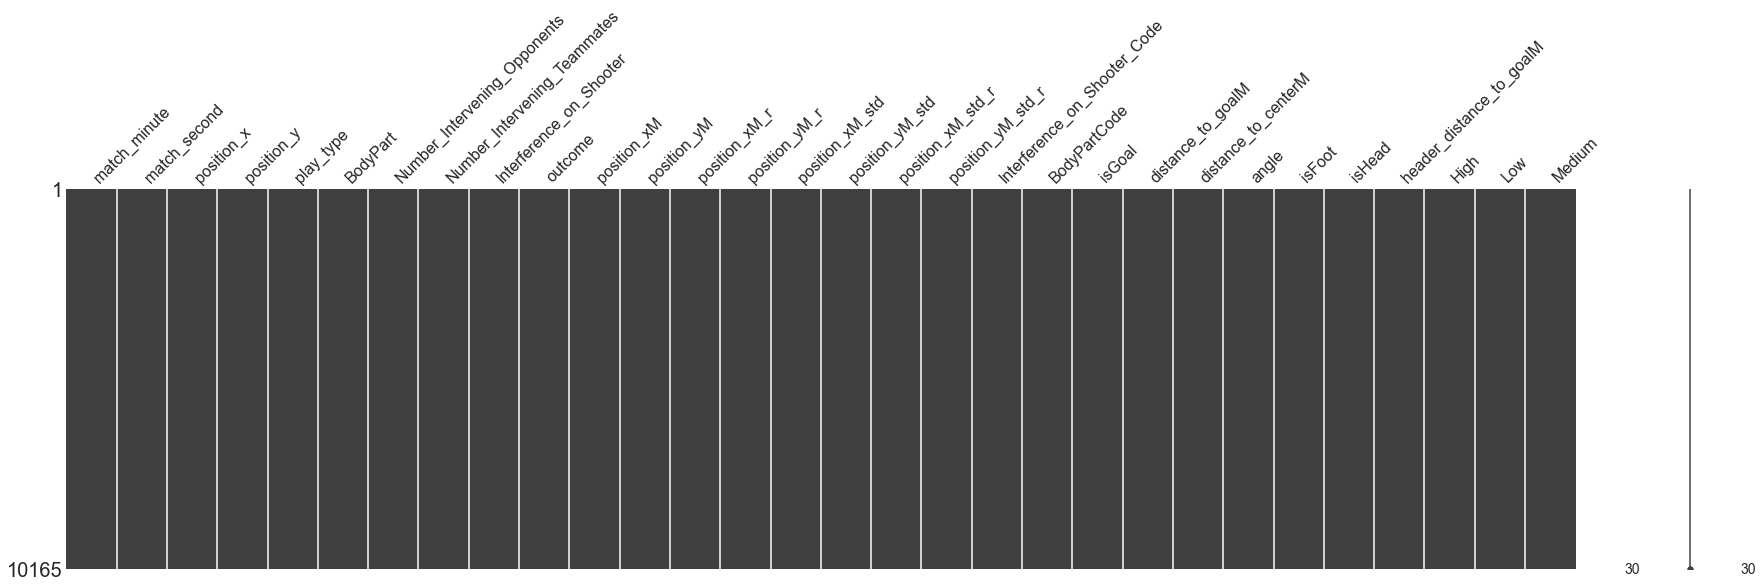

In [22]:
# Plot visualisation of the missing values for each feature of the engineered DataFrame, df_shots
msno.matrix(df_shots, figsize = (30, 7))

In [23]:
# Counts of missing values
null_value_stats = df_shots.isnull().sum(axis=0)
null_value_stats[null_value_stats != 0]

Series([], dtype: int64)

The visualisation shows us very quickly that there are no missing values. Missing values and outliers were treated in the first notebook. The notebook is now ready for modeling with XGBoost.

---

## <a id='#section7'>7. Initial Modeling</a>
First model created as a baseline for which interations of improvement are based.

### <a id='#section7.1'>7.1. Declare feature vector and target variable </a>

In [24]:
# Define features, as determined in the Logistic Regression notebook
features = ['distance_to_goalM',
            'angle',
            'Number_Intervening_Opponents',
            'Number_Intervening_Teammates',
            'isFoot',
            'High',
            'Low',
            'header_distance_to_goalM'
           ]

X = df_shots[features]
y = df_shots['isGoal']

In [25]:
X.head()

,distance_to_goalM,angle,Number_Intervening_Opponents,Number_Intervening_Teammates,isFoot,High,Low,header_distance_to_goalM
0,23.168746,8.057879,3,1,1,0,1,0.000000
1,12.547625,42.642284,1,0,1,0,0,0.000000
2,21.484720,15.533201,3,0,1,0,0,0.000000
3,19.222875,29.625287,2,0,1,0,0,0.000000
4,8.944731,30.208981,3,0,0,0,0,8.944731


In [26]:
y.head()

0    0
1    0
2    0
3    1
4    0
Name: isGoal, dtype: int64

### <a id='#section7.2'>7.2. Convert data to Dmatrix
Convert the dataset into an optimised data structure called Dmatrix that XGBoost supports and gives it acclaimed performance and efficiency gains.

In [27]:
# Define data_dmatrix
#dtrain = xgb.DMatrix(X_train, label=y_train)
#dtest = xgb.DMatrix(X_test, label=y_test)

### <a id='#section7.3'>7.3. Split data into separate training and test set 

In [28]:
# Split X and y into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### <a id='#section7.4'>7.4. Correlation Matrix

In [29]:
df = df_train[features]
corrmat = df.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
g=sns.heatmap(df.corr(), annot=True, cmap='RdYlGn')

NameError: name 'df_train' is not defined

### <a id='#section7.5'>7.5. Train the Baseline XGBoost Classifier
*    In order to train the XGBoost classifier, we need to know different parameters that XGBoost provides.
*    We will discuss these parameters in the next section where they will be tuned
*    Now, its time to train the XGBoost Classifier.
*    We will proceed as follows:

In [ ]:
# Declare initial parameters - will later be tuned      
params = {'max_depth': 6,
          'min_child_weight': 1,
          'eta': 0.3,
          'subsample': 1,
          'colsample_bytree': 1,
          'objective':'binary:logistic'
         }
    
# Instantiate the classifier 
xgb_clf = XGBClassifier(**params)

# Fit the classifier to the training data
xgb_clf.fit(X_train, y_train)

In [ ]:
# View the parameters of the xgb trained model
print(xgb_clf)

### <a id='#section7.6'>7.6. Predictions on Test Data

In [ ]:
# Predict the probabilities of test set
y_pred = xgb_clf.predict_proba(X_test)

print("############\n# XGBoost #\n############")
print(f"Log loss on test set: {sk_metrics.log_loss(y_test, pred_probs):.5f}")
print(f"AUC on test set: {sk_metrics.roc_auc_score(y_test, pred_probs)*100:.2f}%")

In [ ]:
predictions = xgb_clf.predict(X_test)

In [ ]:
df_predictions.head()

In [ ]:
# Convert the Probability Predictions array to a pandas DataFrame
df_predictions = pd.DataFrame(predictions, index=X_test.index, columns=['Predicted_isGoal_default_params'])

# Join the Probability Predictions back onto the original test DataFrame
df_test_predictions_initial = pd.merge(X_test, df_predictions, left_index=True, right_index=True)

# Display DataFrame
df_test_predictions_initial.head()

### <a id='#section7.7'>7.7. Evaluation
We have the starting XGBoost model, which is performing a lot worse than the Logistic Regression alogirthm, with a Log Loss on test set of 0.34204. To beat the performance of the existing Logistic Regression model, we're looking to reduce this Log Loss to around ~0.280.

## <a id='#section8'>8. k-fold Cross Validation using XGBoost
*    To build more robust models with XGBoost, we should always perform k-fold cross validation.
*    In this way, we ensure that the original training dataset is used for both training and validation.
*    Also, each entry is used for validation just once.
*    XGBoost supports k-fold cross validation using the `cv()` method.
*    In this method, we will specify several parameters which are as follows:
     +    `nfolds` - This parameter specifies the number of cross-validation sets we want to build.
     +    `num_boost_round` - It denotes the number of trees we build.
     +    `metrics` - It is the performance evaluation metrics to be considered during CV.
     +    `as_pandas` - It is used to return the results in a pandas DataFrame.
     +    `early_stopping_rounds` - This parameter stops training of the model early if the hold-out metric does not improve for a given number of rounds.
     +    `seed` - This parameter is used for reproducibility of results.

We can use these parameters to build a k-fold cross-validation model by calling XGBoost's `CV()` method.

In [ ]:
params = {'max_depth': 6,
          'min_child_weight': 1,
          'eta': 0.3,
          'subsample': 1,
          'colsample_bytree': 1,
          'objective':'binary:logistic'
         }

xgb_cv = cv(dtrain=data_dmatrix,
            params=params,
            nfold=3,
            num_boost_round=50,
            early_stopping_rounds=10,
            metrics='logloss',    #'auc',
            as_pandas=True,
            seed=123
           )

*    xgb_cv contains train and test auc metrics for each boosting round.
*    Let's preview xgb_cv:

In [ ]:
xgb_cv.head()

## <a id='#section9'>9. Feature Importance with XGBoost
*    XGBoost provides a way to examine the importance of each feature in the original dataset within the model.
*    It involves counting the number of times each feature is split on across all boosting trees in the model.
*    Then we visualize the result as a bar graph, with the features ordered according to how many times they appear.
*    XGBoost has a `plot_importance()` function that helps us to achieve this task.
*    Then we can visualize the features that has been given the highest important score among all the features.
*    Thus XGBoost provides us a way to do feature selection.
*    We will proceed as follows:

In [ ]:
xgb.plot_importance(xgb_clf,
                    ax=plt.gca()
                   )
plt.figure(figsize=(20,15))
plt.show()

*    We can see that the feature `distance_to_goalM` has been given the highest importance score among all the features.
*    Based upon this importance score, we can select the features with highest importance score and discard the redundant ones.
*    Thus XGBoost also gives us a way to do feature selection.

## <a id='#section10'>10. Visualisation of the XGBoost Tree
Using `plot_tree`.

In [ ]:
xgb.plot_tree(xgb_clf,
              ax=plt.gca()
             )
plt.figure(figsize=(20,15)) 
plt.show()

In [ ]:
# plot single tree
plot_tree(xgb_clf)
plt.show()

## <a id='#section11'>11. Hyperperameter Optimisation

### <a id='#section11.1'>11.1. What are hyperparameters?
*    Hyperparameters are certain values or weights that determine the learning process of an algorithm.
*    As stated earlier, XGBoost provides large range of hyperparameters. We can leverage the maximum power of XGBoost by tuning its hyperparameters.
*    The most powerful ML algorithm like XGBoost is famous for picking up patterns and regularities in the data by automatically tuning thousands of learnable parameters.
*    In tree-based models, like XGBoost the learnable parameters are the choice of decision variables at each node.
*    XGBoost is a very powerful algorithm. So, it will have more design decisions and hence large hyperparameters. These are parameters specified by hand to the algo and fixed throughout a training phase.
*    In tree-based models, hyperparameters include things like the maximum depth of the tree, the number of trees to grow, the number of variables to consider when building each tree, the minimum number of samples on a leaf and the fraction of observations used to build a tree.
*    Although we focus on optimizing XGBoost hyperparameters in this kernel, the concepts discussed in this kernel applies to any other advanced ML algorithm as well.

### <a id='#section11.2'>11.2. Hyperparameter types
*    Generally, the XGBoost hyperparameters have been divided into 4 categories. They are as follows:
     +    General parameters
     +    Booster parameters
     +    Learning task parameters
     +    Command line parameters

Before running a XGBoost model, we must set three types of parameters - general parameters, booster parameters and task parameters.

The fourth type of parameter are command line parameters. They are only used in the console version of XGBoost. So, we will skip these parameters and limit our discussion to the first three type of parameters.
    
The following sections goes into more details about each of these parameters, but the most common ones to know about are:
*    `learning_rate`: step size shrinkage used to prevent overfitting. Range is [0,1];
*    `max_depth`: determines how deeply each tree is allowed to grow during any boosting round;
*    `subsample`: percentage of samples used per tree. Low value can lead to underfitting;
*    `colsample_bytree:` percentage of features used per tree. High value can lead to overfitting;
*    `n_estimators`: number of trees you want to build;
*    `objective`: determines the loss function to be used like reg:linear for regression problems, `reg:logistic` for classification problems with only decision, `binary:logistic` for classification problems with probability;
*    `gamma`: controls whether a given node will split based on the expected reduction in loss after the split. A higher value leads to fewer splits. Supported only for tree-based learners;
*    `alpha`: L1 regularization on leaf weights. A large value leads to more regularization; and
*    `lambda`: L2 regularization on leaf weights and is smoother than L1 regularization.
    
To read more about these parameters, see the official documentation [[link](http://xgboost.readthedocs.io/en/latest/parameter.html#general-parameters)].

#### <a id='#section11.2.1'>11.2.1. General parameters
*    These parameters guide the overall functioning of the XGBoost model.
*    In this section, we will discuss three hyperparameters - booster, verbosity and nthread.
*    Visit the [XGBoost General Parameters](https://xgboost.readthedocs.io/en/latest/parameter.html#general-parameters) official documentation for detailed discussion on general parameters.

##### <a id='#section11.2.1.1'>11.2.1.1. `booster`
*    **booster[default = gbtree]**
     +    booster parameter helps us to choose which booster to use.
     +    It helps us to select the type of model to run at each iteration.
     +    It has 3 options - **gbtree**, **gblinear**, or **dart**.
          -    **gbtree** and **dart** - use tree-based models, while
          -    **gblinear** uses linear models.

##### <a id='#section11.2.1.2'>11.2.1.2. `verbosity`
*    **verbosity[default = 1]**
     +    Verbosity of printing messages.
     +    Valid values are 0 (silent), 1 (warning), 2 (info), 3 (debug).

##### <a id='#section11.2.1.3'>11.2.1.3. `nthread`
*    **nthread [default = maximum number of threads available if not set]**
     +    This is number of parallel threads used to run XGBoost.
     +    This is used for parallel processing and number of cores in the system should be entered.
     +    If you wish to run on all cores, value should not be entered and algorithm will detect automatically.

There are other general parameters like **disable_default_eval_metric [default=0]**, **num_pbuffer [set automatically by XGBoost, no need to be set by user]** and **num_feature [set automatically by XGBoost, no need to be set by user]**.

So, these parameters are taken care by XGBoost algorithm itself. Hence, we will not discuss these further.

#### <a id='#section11.2.2'>11.2.2. General parameters
*    We have two types of boosters - **tree booster** and **linear booster**.
*    We will limit our discussion to **tree booster** because it always outperforms the **linear booster** and thus the later is rarely used.
*    Visit the [Parameters for Tree Booster](https://xgboost.readthedocs.io/en/latest/parameter.html#parameters-for-tree-booster) official docs, for detailed discussion on booster parameters.

##### <a id='#section11.2.2.1'>11.2.2.1. `eta`
*    **eta [default=0.3, alias: learning_rate]**
     +    It is analogous to learning rate in GBM.
     +    It is the step size shrinkage used in update to prevent overfitting.
     +    After each boosting step, we can directly get the weights of new features, and eta shrinks the feature weights to make the boosting process more conservative.
     +    It makes the model more robust by shrinking the weights on each step.
     +    range : [0,1]
     +    Typical final values : 0.01-0.2.

##### <a id='#section11.2.2.2'>11.2.2.2. `gamma`
*    **eta [default=0.3, alias: learning_rate]**
     +    It is analogous to learning rate in GBM.
     +    It is the step size shrinkage used in update to prevent overfitting.
     +    After each boosting step, we can directly get the weights of new features, and eta shrinks the feature weights to make the boosting process more conservative.
     +    It makes the model more robust by shrinking the weights on each step.
     +    range : [0,1]
     +    Typical final values : 0.01-0.2.

##### <a id='#section11.2.2.3'>11.2.2.3. `max_depth`
*    **max_depth [default=6]**
     +    The maximum depth of a tree, same as GBM.
     +    It is used to control over-fitting as higher depth will allow model to learn relations very specific to a particular sample.
     +    Increasing this value will make the model more complex and more likely to overfit.
     +    The value 0 is only accepted in lossguided growing policy when tree_method is set as hist and it indicates no limit on depth.
     +    We should be careful when setting large value of max_depth because XGBoost aggressively consumes memory when training a deep tree.
     +    range: [0,∞] (0 is only accepted in lossguided growing policy when tree_method is set as hist.
     +    Should be tuned using CV.
     +    Typical values: 3-10

In [ ]:
# add the rest of the hyperparameter descriptions here
# fix numbering

### <a id='#section11.3'>11.3. Optimisation
Parameters can be optimised in a number of ways, two of which are discussed in the following sections:
*    Random Search ([section 11.3.1](#section11.3.1)); and
*    Grid Search ([section 11.3.2](#section11.3.2)).

#### <a id='#section11.3.1'>11.3.1. Random Search

In [ ]:
# A parameter grid for XGBoost
params = {'min_child_weight': [1, 5, 10],
          'gamma': [0.5, 1, 1.5, 2, 5],
          'subsample': [0.6, 0.8, 1.0],
          'colsample_bytree': [0.6, 0.8, 1.0],
          'max_depth': [3, 4, 5]
         }

In [ ]:
xgb_clf = XGBClassifier(learning_rate=0.02,
                        n_estimators=600,
                        objective='binary:logistic',
                        silent=True,
                        nthread=1
                       )

In [ ]:
folds=3
param_comb=5

skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=42)

random_search = RandomizedSearchCV(xgb_clf,
                                   param_distributions=params,
                                   n_iter=param_comb,
                                   scoring='neg_log_loss',    # for all scoring metrics see sorted(sklearn.metrics.SCORERS.keys()), link: https://scikit-learn.org/stable/modules/model_evaluation.html
                                   n_jobs=4,
                                   cv=skf.split(X_train, y_train),
                                   verbose=3,
                                   random_state=1001
                                  )

# Run
start_time = timer(None)
random_search.fit(X_train, y_train)
timer(start_time)

In [ ]:
print('\n All results:')
print(random_search.cv_results_)
print('\n Best estimator:')
print(random_search.best_estimator_)
print('\n Best normalized gini score for %d-fold search with %d parameter combinations:' % (folds, param_comb))
print(random_search.best_score_ * 2 - 1)
print('\n Best hyperparameters:')
print(random_search.best_params_)

In [ ]:
y_test_fit = random_search.predict_proba(y_test)
df_results_random_search = pd.DataFrame(data={'id':test_df['id'], 'target':y_test_fit[:,1]})
#df_results_random_search.to_csv('...csv', index=False)

#### <a id='#section11.3.2'>11.3.2. Grid Search

In [ ]:
folds=3
param_comb=5

skf = StratifiedKFold(n_splits=folds,
                      shuffle=True,
                      random_state=42
                     )

grid = GridSearchCV(estimator=xgb_clf,
                    param_grid=params,
                    scoring='neg_log_loss',
                    n_jobs=4,
                    cv=skf.split(X_train, y_train),
                    verbose=3
                   )

# Run
start_time = timer(None)
grid.fit(X_train, y_train)
timer(start_time)

In [ ]:
print('\n All results:')
print(grid.cv_results_)
print('\n Best estimator:')
print(grid.best_estimator_)
print('\n Best score:')
print(grid.best_score_ * 2 - 1)
print('\n Best parameters:')
print(grid.best_params_)
df_results_grid = pd.DataFrame(grid.cv_results_)
#df_results.to_csv('...csv', index=False)

In [ ]:
grid.best_params_

In [ ]:
y_pred = grid.best_estimator_.predict_proba(X_test)
#df_results_grid = pd.DataFrame(data={'id':test_df['id'], 'target':y_test[:,1]})
#df_results_grid.to_csv('....csv', index=False)

print("############\n# XGBoost #\n############")
print(f"Log loss on test set: {sk_metrics.log_loss(y_test, y_pred):.5f}")
#print(f"AUC on test set: {sk_metrics.roc_auc_score(y_test, y_pred)*100:.2f}%")

In [ ]:
# Convert the Probability Predictions array to a pandas DataFrame
df_predictions = pd.DataFrame(y_pred , columns = ['prob_no_goal', 'prob_goal'])

# Join the Probability Predictions back onto the original test DataFrame
df_test_predictions_initial = pd.merge(X_test, df_predictions, left_index=True, right_index=True)

# Display DataFrame
df_test_predictions_initial.head()

## <a id='#section12'>12. Final Optimised XGBoost Model</a>

In [ ]:
{'colsample_bytree': 0.8,
 'gamma': 0.5,
 'max_depth': 3,
 'min_child_weight': 1,
 'subsample': 1.0}

In [ ]:
# Declare parameters
params = {'colsample_bytree': 0.7634432872628131,
          'gamma': 8.813272293476338,
          'max_depth': 10,
          'min_child_weight': 9.0,
          'reg_alpha': 73.0,
          'reg_lambda': 0.24969380798546292
         #'objective':'binary:logistic',
         #'max_depth': 4,
         #'alpha': 10,
         #'learning_rate': 1.0,
         #'n_estimators':100
         }         
           
          
# Instantiate the classifier 
xgb_clf_final = XGBClassifier(**params)

# Fit the classifier to the training data
xgb_clf_final.fit(X_train, y_train)

In [ ]:
# View the parameters of the final xgb trained model
print(xgb_clf_final)

In [ ]:
# Predict the probabilities of test set
y_pred_final = xgb_clf_final.predict_proba(X_test)

print("############\n# XGBoost #\n############")
print(f"Log loss on test set: {sk_metrics.log_loss(y_test, y_pred_final):.5f}")
#print(f"AUC on test set: {sk_metrics.roc_auc_score(y_test, y_pred_final)*100:.2f}%")

---

## <a id='#section13'>13. Performance comparison of XGBoost with Logistic Regression</a>

#### Training of the Logistic Regression

In [ ]:
# Training of the Logistic Regression on the Train set
model_lr = LogisticRegression(random_state=42)
model_lr.fit(df_train[features], np.array(df_train['isGoal']).ravel())

# Prediction on the Test set
pred_probs = model_lr.predict_proba(df_test[features])[:,1]

print("#################\n# Logistic reg. #\n#################")
print(f"Log loss on test set: {sk_metrics.log_loss(df_test['isGoal'], pred_probs):.5f}")
print(f"AUC on test set: {sk_metrics.roc_auc_score(df_test['isGoal'], pred_probs)*100:.2f}%")

## <a id='#section14'>14. Assessment of the Performance of the Teams in Game 2 of the Metrica Sports Shot Data
The next stage of this analysis to take the Chance Quality Model derived and apply it to the DataFrame of identified shots from game 2 of the sample Metrica Sports data. to determine which team deserved to win the game, based solely on the quality of chances that each team created.

### <a id='#section14.1'>14.1. Apply the Trained Chance Quality Model from XGBoost to the Metrica Sports Data

##### Import Metrica Sports Shots data for game 2

In [30]:
# Read data directory
print(glob.glob(os.path.join(data_dir_metrica, 'engineered/*')))

['../../data/metrica-sports/engineered/game_2_shots.csv', '../../data/metrica-sports/engineered/archive', '../../data/metrica-sports/engineered/submitted', '../../data/metrica-sports/engineered/game_2_shots_with_xg.csv']


In [31]:
# Read in exported Metrica Sports game 2 shots CSV as a pandas DataFrame
df_metrica = pd.read_csv(os.path.join(data_dir_metrica, 'engineered', 'game_2_shots.csv'))

In [32]:
# Embed video of the 24 shots in game 2 of the Metrica Sports sample data
Video('../../video/fig/metrica-sports/tracking_shots_all.mp4', width=770, height=530)

##### Transform Metrica Sports data to be compatible with trained Chance Quality Model

In [ ]:
# Define function to transform both the Chance Quality model and the Metrica Sports data to be compatible with trained Chance Quality Model
def transformation_metrica_test_train(df):
    """
    Function performs all transformation steps defined in the section *Univariate analysis - Part A*
    """
    
    df = df.copy()
    
    # Drop 'BodyPart' == 'Unknown'
    df = df[df['BodyPart'] != 'Other']
    
    # Drop 'Interference_on_Shooter' == 'Unknown'
    df = df[df['Interference_on_Shooter'] != 'Unknown']
    
    # Compute the distance to the center - distance_to_centerM
    df['distance_to_centerM'] = np.abs(df['position_yM'])
    
    # Computer whether the shot is taken with the foot or head
    df['isFoot'] = df['BodyPart'].map(dict_isFoot)
    df['isHead'] = df['BodyPart'].map(dict_isHead)

    # Compute header distance to goal
    df['header_distance_to_goalM'] = df['isHead'] * df['distance_to_goalM']
    
    # One-hot encode the Interference on the Shooter
    
    ## One-hot encoding
    df_dummy_interference_on_shooter = pd.get_dummies(df['Interference_on_Shooter'])
    
    # Attach separate columns back onto the dataset
    df = pd.concat([df, df_dummy_interference_on_shooter], axis=1)
    
    return df

In [ ]:
# Transform Test and Train data
df_train_metrica = transformation_metrica_test_train(df_train_raw)
df_test_metrica = transformation_metrica_test_train(df_test_raw)

In [ ]:
# Define function to transform both the Chance Quality model and the Metrica Sports data to be compatible with trained Chance Quality Model
def transformation_metrica(df):
    """
    Function performs all transformation steps defined in the section *Univariate analysis - Part A*
    """
    
    df = df.copy()
    
    # Drop 'BodyPart' == 'Unknown'
    df = df[df['BodyPart'] != 'Other']
    
    # Drop 'Interference_on_Shooter' == 'Unknown'
    df = df[df['Interference_on_Shooter'] != 'Unknown']
    
    # Compute the distance to the center - distance_to_centerM
    df['distance_to_centerM'] = np.abs(df['position_yM'])
    
    # Computer whether the shot is taken with the foot or head
    # df['isFoot'] = df['BodyPart'].map(dict_isFoot)
    # df['isHead'] = df['BodyPart'].map(dict_isHead)

    # Compute header distance to goal
    df['header_distance_to_goalM'] = df['isHead'] * df['distance_to_goalM']
    
    # One-hot encode the Interference on the Shooter
    
    ## One-hot encoding
    df_dummy_interference_on_shooter = pd.get_dummies(df['Interference_on_Shooter'])
    
    # Attach separate columns back onto the dataset
    df = pd.concat([df, df_dummy_interference_on_shooter], axis=1)
    
    return df

In [ ]:
# Transform Metrica Sports data 
df_metrica_trans = transformation_metrica(df_metrica)

##### Create Metrica Sports XGBoost Model

In [ ]:
features = ['distance_to_goalM',
           #'distance_to_centerM',
            'angle',
            'Number_Intervening_Opponents',
            'Number_Intervening_Teammates',
           #'isFoot',   # potential remove this one as deemed non-monotic
           #'isHead',   # potential remove this one as deemed non-monotic
            'High',     # 'Interference_on_Shooter'
           #'Medium',   # 'Interference_on_Shooter'
            'Low',       # 'Interference_on_Shooter'
            'header_distance_to_goalM'
           ]

# Training of the logistic regression on the train set
reg_metrica = LogisticRegression(random_state=42)
reg_metrica.fit(df_train_trans[features], np.array(df_train_trans['isGoal']).ravel())

# Prediction on the test set
pred_probs = reg_metrica.predict_proba(df_test_trans[features])[:,1]
print(f"Log loss on test set after univariate analysis part A: {sk_metrics.log_loss(df_test_trans['isGoal'], pred_probs):.5f}")
print(f"AUC on test set after univariate analysis part A: {sk_metrics.roc_auc_score(df_test_trans['isGoal'], pred_probs)*100:.2f}%")

##### Probability Predictions

In [ ]:
# Convert the Probability Predictions array to a pandas DataFrame
df_metrica_predictions = pd.DataFrame(yNew, columns = ['prob_no_goal', 'prob_goal'])

In [ ]:
# Join the Probability Predictions back onto the original Metrica shots DataFrame
df_metrica_xg = pd.merge(df_metrica, df_metrica_predictions, left_index=True, right_index=True)

# Display DataFrame
df_metrica_xg.head()

### <a id='#section14.2'>14.2. Assessment of the Performance of the Teams in Game 2 of the Metrica Sports Shot Data

In [ ]:
df_metrica_xg['xG'] = df_metrica_xg['prob_goal']
df_metrica_xg['xG'] = np.where(df_metrica_xg['isPenalty'] == 1, 0.76, df_metrica_xg['xG'])

In [ ]:
# Create xG Race Chart with revised xG for penalties

## Assign DataFrame
df = df_metrica_xg

## Create four lists to plot the different xG values - home, away, xG, and minutes. We start these with zero so our charts will start at 0
a_xG = [0]
h_xG = [0]
a_min = [0]
h_min = [0]

## Define team names from the DataFrame
hteam = 'Home'
ateam = 'Away'

## For loop to append the xG and minute for both the Home and Away teams
for x in range(len(df['xG'])):
    if df['team'][x]==ateam:
        a_xG.append(df['xG'][x])
        a_min.append(df['match_minute'][x])
    if df['team'][x]==hteam:
        h_xG.append(df['xG'][x])
        h_min.append(df['match_minute'][x])
        
## Function we use to make the xG values be cumulative rather than single shot values. Foes through the list and adds the numbers together
def nums_cumulative_sum(nums_list):
    return [sum(nums_list[:i+1]) for i in range(len(nums_list))]

## Apply defned nums_cumulative_sum function to the home and away xG lists
a_cumulative = nums_cumulative_sum(a_xG)
h_cumulative = nums_cumulative_sum(h_xG)

## Find the total xG. Create a new variable from the last item in the cumulative list
alast = round(a_cumulative[-1],2)
hlast = round(h_cumulative[-1],2)

## Set background colour
background = 'aliceblue'

## Create figure 
fig, ax = plt.subplots(figsize=(15, 6))
fig.set_facecolor(background)
ax.patch.set_facecolor(background)

# Set up our base layer
mpl.rcParams['xtick.color'] = 'midnightblue'
mpl.rcParams['ytick.color'] = 'midnightblue'

## Create xG Race Chart
plt.xticks([0, 15, 30, 45, 60, 75, 90])
plt.xlabel('Minute', fontfamily='DejaVu Sans', color='midnightblue', fontsize=16)
plt.ylabel('xG', fontfamily='DejaVu Sans', color='midnightblue', fontsize=16)

# Plot the step graphs
ax.step(x=a_min, y=a_cumulative, color='blue', label=ateam, linewidth=5, where='post')
ax.step(x=h_min, y=h_cumulative, color='red', label=ateam, linewidth=5, where='post')

## Set Gridlines 
ax.grid(linewidth=0.25, color='midnightblue', axis='y', zorder=1)
spines = ['top','bottom','left','right']
for x in spines:
    if x in spines:
        ax.spines[x].set_visible(False)

## Set title
ax.set_title('xG Race Chart',
             loc='center',
             color='midnightblue', 
             fontweight='bold',
             fontfamily='DejaVu Sans',
             fontsize=22,
            )

## Show Legend
#plt.legend()

## Save figure
if not os.path.exists(fig_shots_dir + '/metrica_shots_race_chart_xg_xgboost.png'):
    plt.savefig(fig_shots_dir + '/metrica_shots_race_chart_xg_xgboost.png', bbox_inches='tight', dpi=300)
else:
    pass

## Show figure
plt.tight_layout()
plt.show()

### <a id='#section14.3'>14.3. Comparison of the XGBoost and Logistic Regression Predictions

In [ ]:
# ADD HERE

## <a id='#section15'>15. Summary</a>
To summarise, this notebook ...

---

## <a id='#section16'>16. Next Steps</a>
...

---

## <a id='#section17'>17. References and Further Reading</a>

### XGBoost
*    https://www.kaggle.com/prashant111/xgboost-k-fold-cv-feature-importance
*    https://www.kaggle.com/prashant111/a-guide-on-xgboost-hyperparameters-tuning
*    https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/
*    https://www.datacamp.com/community/tutorials/xgboost-in-python
*    https://blog.cambridgespark.com/getting-started-with-xgboost-3ba1488bb7d4
*    https://towardsdatascience.com/a-beginners-guide-to-xgboost-87f5d4c30ed7
*    https://heartbeat.fritz.ai/boosting-your-machine-learning-models-using-xgboost-d2cabb3e948f
*    https://towardsdatascience.com/https-medium-com-vishalmorde-xgboost-algorithm-long-she-may-rein-edd9f99be63d
*    https://medium.com/@gabrieltseng/gradient-boosting-and-xgboost-c306c1bcfaf5
*    https://medium.com/mlreview/gradient-boosting-from-scratch-1e317ae4587d
*    https://xgboost.readthedocs.io/en/latest/tutorials/param_tuning.html
*    https://xgboost.readthedocs.io/en/latest/parameter.html#general-parameters
*    https://medium.com/analytics-vidhya/hyperparameter-tuning-hyperopt-bayesian-optimization-for-xgboost-and-neural-network-8aedf278a1c9
*    https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/
*    https://www.kaggle.com/yassinealouini/hyperopt-the-xgboost-model

### Expected Goals models

#### Data
*    [StatsBomb](https://statsbomb.com/)'s latest 360 release [[link](https://statsbomb.com/2021/02/statsbomb-360-and-evolve/)]
*    [Impect](https://www.impect.com/en/about-us)'s 'Packing' metric [[link](https://www.youtube.com/watch?v=fk8yAQU9U1E&ab_channel=IMPECT)].

#### Seminars and videos
*    The Ultimate Guide to Expected Goals by David Sumpter for Friends of Tracking: https://www.youtube.com/watch?v=310_eW0hUqQ
*    How to explain Expected Goals to a football player by David Sumpter: https://www.youtube.com/watch?v=Xc6IG9-Dt18 
*    What is xG? by Alex Stewart for Tifo Football: https://www.youtube.com/watch?v=zSaeaFcm1SY
*    Opta Expected Goals presented by Duncan Alexander: https://www.youtube.com/watch?v=w7zPZsLGK18 
*    Sam Green OptaPro Interview: https://www.youtube.com/watch?v=gHIY-MgDh_o 
*    Anatomy of a Goal (with Sam Green) for Numberphile: https://www.youtube.com/watch?v=YJuHC7xXsGA 

#### Tutorials
*    Friends of Tracking Expected Goals tutorials by David Sumpter:
     +    Seminars:
          -    Part 1 – How to build an Expected Goals model 1 – Data and model: https://www.youtube.com/watch?v=bpjLyFyLlXs
          -    Part 2 – How to build an Expected Goals model 2 – Statistical fitting: https://www.youtube.com/watch?v=wHOgINJ5g54 
*    GitHub repository:
     +    xG model: https://github.com/Friends-of-Tracking-Data-FoTD/SoccermaticsForPython/blob/master/3xGModel.py
     +    Linear regression: https://github.com/Friends-of-Tracking-Data-FoTD/SoccermaticsForPython/blob/master/4LinearRegression.py
     +    xG model fit: https://github.com/Friends-of-Tracking-Data-FoTD/SoccermaticsForPython/blob/master/5xGModelFit.py 

#### Notable xG models
*    Sam Green: https://www.optasportspro.com/news-analysis/assessing-the-performance-of-premier-league-goalscorers/ 
*    Michael Caley: https://cartilagefreecaptain.sbnation.com/2014/9/11/6131661/premier-league-projections-2014#methoderology 

#### Professional and Fanalyst examples:
*    An xG Model for Everyone in 20 minutes (ish) by Paul Riley: https://differentgame.wordpress.com/2017/04/29/an-xg-model-for-everyone-in-20-minutes-ish/ 
*    [Tech how-to: build your own Expected Goals model by SciSports](https://www.scisports.com/tech-how-to-build-your-own-expected-goals-model/). For code, see: https://bitbucket.org/scisports/ssda-how-to-expected-goals/src/master/
soccer_analytics repository by Kraus Clemens: https://github.com/CleKraus/soccer_analytics/ 
*    Expected goal model using Logistic Regression: https://github.com/CleKraus/soccer_analytics/blob/master/notebooks/expected_goal_model_lr.ipynb 
*    Challenges using Gradient Boosters: https://github.com/CleKraus/soccer_analytics/blob/master/notebooks/challenges_with_gradient_boosters.ipynb 
*    Expected Goals thesis by Andrew Rowlinson: https://github.com/andrewRowlinson/expected-goals-thesis 
*    Expected Goals deep dive by Andrew Puopolo: https://github.com/andrewsimplebet/expected_goals_deep_dive
*    [Fitting your own football xG model](https://www.datofutbol.cl/xg-model/) by Ismael Gomez
*    [Python for Fantasy Football – Introduction to Machine Learning](http://www.fantasyfutopia.com/python-for-fantasy-football-introduction-to-machine-learning/) by Fantasy Futopia (Thomas Whelan)

#### Articles:
*    xG explained by FBref: https://fbref.com/en/expected-goals-model-explained/ 
*    Should you write about real goals or expected goals? A guide for journalists by David Sumpter (@Soccermatics): https://soccermatics.medium.com/should-you-write-about-real-goals-or-expected-goals-a-guide-for-journalists-2cf0c7ec6bb6 
*    [How Data Availability affects the ability to learn good xG models](https://dtai.cs.kuleuven.be/sports/blog/how-data-availability-affects-the-ability-to-learn-good-xg-models) by [Jesse Davis](https://twitter.com/jessejdavis1) and [Pieter Robberechts](https://twitter.com/p_robberechts) for [KU Leuven](https://www.kuleuven.be/kuleuven/)
*    Expected Goals and Unexpected Goals by Garry Gelade: https://web.archive.org/web/20200724125157/http://business-analytic.co.uk/blog/expected-goals-and-unexpected-goals/ 
*    Assessing Expected Goals Models. Part 1: Shots by Garry Gelade: https://web.archive.org/web/20200724125157/http://business-analytic.co.uk/blog/evaluating-expected-goals-models/
*    Assessing Expected Goals Models. Part 2: Anatomy of a Big Chance by Garry Gelade: https://web.archive.org/web/20200724125157/http://business-analytic.co.uk/blog/assessing-expected-goals-models-part-2-anatomy-of-a-big-chance/ 

#### Literature:
*    Expected Goals literature: https://docs.google.com/document/d/1OY0dxqXIBgncj0UDgb97zOtczC-b6JUknPFWgD77ng4/edit 


### Visualisation
*    [How to Draw a Football Pitch](http://petermckeever.com/2020/10/how-to-draw-a-football-pitch/) by Peter McKeever
*    [How To Create xG Flow Charts in Python](https://www.youtube.com/watch?v=bvoOOYMQkac) by [McKay Johns](https://twitter.com/mckayjohns). For code, see [[link](https://github.com/mckayjohns/Viz-Templates)]
*    [How to Make a Plot with Two Different Y-axis in Python with Matplotlib](https://cmdlinetips.com/2019/10/how-to-make-a-plot-with-two-different-y-axis-in-python-with-matplotlib/)
*    https://stackoverflow.com/questions/39409866/correlation-heatmap
*    [Control color in seaborn heatmaps](https://www.python-graph-gallery.com/92-control-color-in-seaborn-heatmaps)

---

***Visit my website [EddWebster.com](https://www.eddwebster.com) or my [GitHub Repository](https://github.com/eddwebster) for more projects. If you'd like to get in contact, my Twitter handle is [@eddwebster](http://www.twitter.com/eddwebster) and my email is: edd.j.webster@gmail.com.***

[Back to the top](#top)